In [1]:
%matplotlib inline


# Simulating results

We now use a Poisson regression to fit a model to the Premier League
and then we use the estimated values to simulate results between
two teams.

This code is adapted from
https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/


In [2]:
# importing the tools required for the Poisson regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from scipy.stats import poisson,skellam

## Import data
Here we use football-data.co.uk



In [3]:
epl = pd.read_csv("https://www.football-data.co.uk/mmz4281/2122/E0.csv")
ep = epl[['HomeTeam','AwayTeam','FTHG','FTAG']]
epl = epl.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
epl.head()

epl = epl[:-10]

## Perform the regression
In the fit, we include a parameter for home advantage.
Team and opponent are fixed effects.



In [4]:
goal_model_data = pd.concat([epl[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           epl[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data,
                        family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  740
Model:                            GLM   Df Residuals:                      700
Model Family:                 Poisson   Df Model:                           39
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1043.1
Date:                Tue, 08 Oct 2024   Deviance:                       776.72
Time:                        23:00:22   Pearson chi2:                     681.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2498
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.2470      0.203      1.214      0.225      -0.152       0.646
team[T.Aston Villa]           -0.1298      0.195     -0.666      0.506      -0.512       0.252
team[T.Brentford]             -0.1589      0.198     -0.802      0.423      -0.547       0.230
team[T.Brighton]              -0.3735      0.209     -1.788      0.074      -0.783       0.036
team[T.Burnley]               -0.5263      0.220     -2.395      0.017      -0.957      -0.096
team[T.Chelsea]                0.2714      0.177      1.529      0.126      -0.077       0.619
team[T.Crystal Palace]        -0.1370      0.196     -0.699      0.484      -0.521       0.247
team[T.Everton]               -0.2847      0.204     -1.394      0.163      -0.685       0.116
team[T.Leeds]                 -0.3127      0.207     -1.507      0.132      -0.719       0.094
team[T.Leicester]              0.0481      0.188      0.256      0.798      -0.320       0.416
team[T.Liverpool]              0.4522      0.170      2.657      0.008       0.119       0.786
team[T.Man City]               0.5115      0.168      3.036      0.002       0.181       0.842
team[T.Man United]             0.0156      0.189      0.083      0.934      -0.354       0.385
team[T.Newcastle]             -0.2841      0.204     -1.389      0.165      -0.685       0.117
team[T.Norwich]               -0.8697      0.248     -3.507      0.000      -1.356      -0.384
team[T.Southampton]           -0.2770      0.205     -1.354      0.176      -0.678       0.124
team[T.Tottenham]              0.1294      0.183      0.706      0.480      -0.230       0.489
team[T.Watford]               -0.5181      0.220     -2.357      0.018      -0.949      -0.087
team[T.West Ham]               0.0398      0.187      0.213      0.831      -0.327       0.406
team[T.Wolves]                -0.4429      0.212     -2.088      0.037      -0.859      -0.027
opponent[T.Aston Villa]        0.1071      0.203      0.529      0.597      -0.290       0.504
opponent[T.Brentford]          0.1297      0.200      0.649      0.516      -0.262       0.521
opponent[T.Brighton]          -0.0994      0.211     -0.470      0.638      -0.514       0.315
opponent[T.Burnley]            0.0579      0.202      0.286      0.775      -0.339       0.455
opponent[T.Chelsea]           -0.3702      0.230     -1.613      0.107      -0.820       0.080
opponent[T.Crystal Palace]    -0.0219      0.208     -0.105      0.916      -0.429       0.385
opponent[T.Everton]            0.2573      0.194      1.325      0.185      -0.123       0.638
opponent[T.Leeds]              0.4973      0.185      2.688      0.007       0.135       0.860
opponent[T.Leicester]          0.2134      0.197      1.085      0.278      -0.172       0.599
opponent[T.Liverpool]         -0.6001      

## Simulating a game
Let's now simulate a match between City and Arsenal



In [5]:
# Set teams here
home_team='Man City'
away_team='Arsenal'

#Predict for Arsenal vs. Manchester City
home_score_rate=poisson_model.predict(pd.DataFrame(data={'team': home_team, 'opponent': away_team,
                                       'home':1},index=[1]))
away_score_rate=poisson_model.predict(pd.DataFrame(data={'team': away_team, 'opponent': home_team,
                                       'home':0},index=[1]))
print(home_team + ' against ' + away_team + ' expect to score: ' + str(home_score_rate))
print(away_team + ' against ' + home_team + ' expect to score: ' + str(away_score_rate))

#Lets just get a result
home_goals=np.random.poisson(home_score_rate)
away_goals=np.random.poisson(away_score_rate)
print(home_team + ': ' + str(home_goals[0]))
print(away_team + ': '  + str(away_goals[0]))

Man City against Arsenal expect to score: 1    2.481142
dtype: float64
Arsenal against Man City expect to score: 1    0.682894
dtype: float64
Man City: 3
Arsenal: 1


## Two-dimensional histogram of scores
This gives the probability of different score lines.



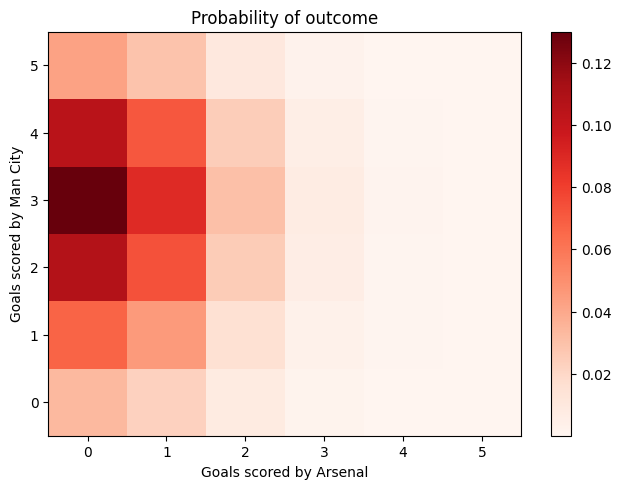

In [6]:
# Code to caluclate the goals for the match.
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam,
                                                           'opponent': awayTeam, 'home': 1},
                                                     index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam,
                                                           'opponent': homeTeam, 'home': 0},
                                                     index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals + 1)] for team_avg in
                 [home_goals_avg, away_goals_avg]]
    return (np.outer(np.array(team_pred[0]), np.array(team_pred[1])))

#Fill in the matrix
max_goals=5
score_matrix=simulate_match(poisson_model, home_team, away_team,max_goals)

fig=plt.figure()
ax=fig.add_subplot(1,1,1)
pos=ax.imshow(score_matrix, extent=[-0.5,max_goals+0.5,-0.5,max_goals+0.5], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Probability of outcome')
plt.xlim((-0.5,5.5))
plt.ylim((-0.5,5.5))
plt.tight_layout()
ax.set_xlabel('Goals scored by ' + away_team)
ax.set_ylabel('Goals scored by ' + home_team)
plt.show()

#Home, draw, away probabilities
homewin=np.sum(np.tril(score_matrix, -1))
draw=np.sum(np.diag(score_matrix))
awaywin=np.sum(np.triu(score_matrix, 1))